For the geographic sanitary regions: https://analisi.transparenciacatalunya.cat/Salut/Regions-sanit-ries/q2jd-tqye/about_data
For the population data: https://analisi.transparenciacatalunya.cat/Salut/Registre-central-de-poblaci-del-CatSalut-poblaci-p/ftq4-h9vk/about_data

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
C:\Users\gerar\AppData\Local\Temp\ipykernel_26220\1401893639.py:6: SyntaxWarning: invalid escape sequence '\D'
  gdf = gpd.read_file('.\Data\Ad_Dataset.geojson')
C:\Users\gerar\AppData\Local\Temp\ipykernel_26220\1401893639.py:9: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv(".\Data\clean_data.csv", encoding='latin-1')


Before mapping:
GeoDataFrame regions: ['Lleida' 'Camp de Tarragona' "Terres de l'Ebre" 'Girona'
 'Catalunya Central' 'Penedès' 'Alt Pirineu i Aran'
 'Barcelona Metropolitana Sud' 'Barcelona Metropolitana Nord'
 'Barcelona Ciutat' 'No consta']
CSV regions: ['ALT PIRINEU i ARAN' 'BARCELONA' 'BARCELONA CIUTAT'
 'BARCELONA METROPOLITANA NORD' 'BARCELONA METROPOLITANA SUD'
 'CAMP DE TARRAGONA' 'CATALUNYA CENTRAL' 'GIRONA' 'LLEIDA' 'PENEDÃ\x88S'
 "TERRES DE L'EBRE"]

After mapping:
GeoDataFrame regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'No consta', 'Penedès', "Terres de l'Ebre"]
CSV regions: ['Alt Pirineu i Aran', 'Barcelona Ciutat', 'Barcelona Metropolitana Nord', 'Barcelona Metropolitana Sud', 'Camp de Tarragona', 'Catalunya Central', 'Girona', 'Lleida', 'Penedès', "Terres de l'Ebre"]

Merged GeoDataFrame shape: (12, 8)
Merged data head:
     regió sanitàri

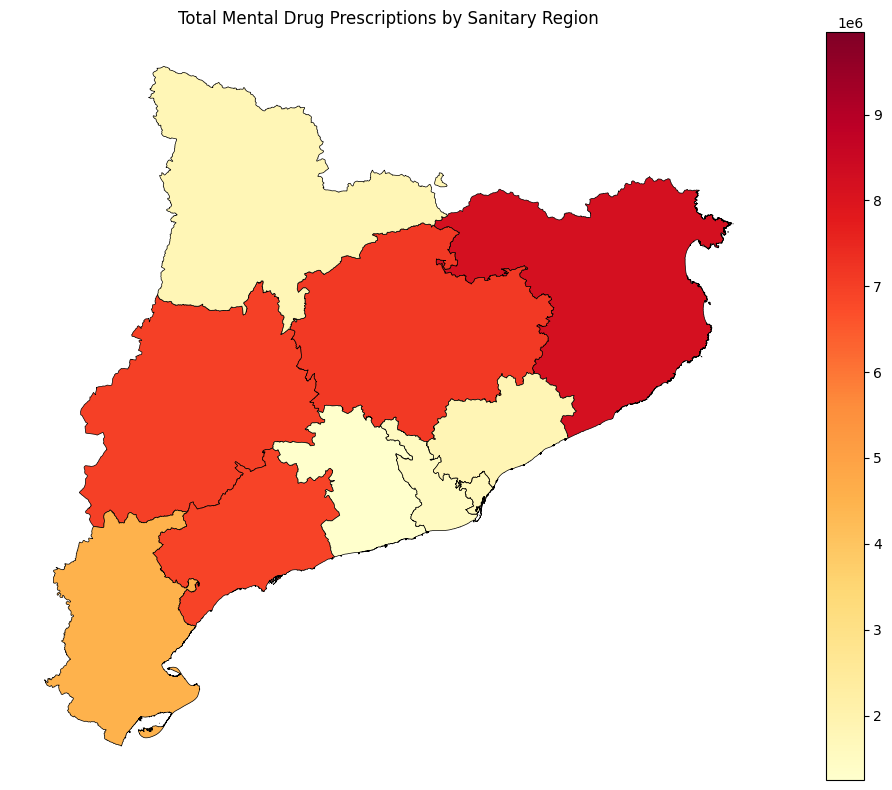

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the GeoJSON file
gdf = gpd.read_file('.\Data\Ad_Dataset.geojson')

# Read the CSV file
df = pd.read_csv(".\Data\clean_data.csv", encoding='latin-1')

# Rename the corrupted column names
column_mapping = {
    'regiÃ³ sanitÃ ria': 'regió sanitària',
}
df = df.rename(columns=column_mapping)

# Select the columns we need
columns_to_merge = df[['regió sanitària', 'grup ATC nivell 3', 'nombre de receptes']]

# Filter for mental groups
mental_groups = [
    "ANTIDEPRESIVOS",
    "ANSIOLITICOS",
    "ANTIPSICOTICOS", 
    "HIPNOTICOS Y SEDANTES",
    "FARMACOS USADOS EN DESORDENES ADICTIVOS",
    "PSICOLEPTICOS Y PSICOANALEPTICOS EN COMBINACION",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA EL TDAH Y NOOTROPICOS",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA ADHD Y NOOTROPICOS",
    "OTROS FARMACOS QUE ACTUAN SOBRE EL SISTEMA NERVIOSO"
]

mental_drugs_df = columns_to_merge[columns_to_merge['grup ATC nivell 3'].isin(mental_groups)]

# SUM ALL mental drug prescriptions grouped ONLY by sanitary region
summed_by_region = mental_drugs_df.groupby('regió sanitària')['nombre de receptes'].sum().reset_index()

# Rename the 'nom' column in GeoDataFrame to match
gdf = gdf.rename(columns={'nom': 'regió sanitària'})

print("Before mapping:")
print(f"GeoDataFrame regions: {gdf['regió sanitària'].unique()}")
print(f"CSV regions: {summed_by_region['regió sanitària'].unique()}")

# Create a mapping dictionary to standardize region names
region_mapping = {
    'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
    'ALTRES': 'No consta',  # Map 'ALTRES' to 'No consta'
    'BARCELONA': 'Barcelona Ciutat',  # Assuming BARCELONA refers to Barcelona Ciutat
    'BARCELONA CIUTAT': 'Barcelona Ciutat',
    'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
    'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
    'CAMP DE TARRAGONA': 'Camp de Tarragona',
    'CATALUNYA CENTRAL': 'Catalunya Central',
    'GIRONA': 'Girona',
    'LLEIDA': 'Lleida',
    'PENEDÃ\x88S': 'Penedès',  # Fix encoding issue
    'SENSE ESPECIFICAR': 'No consta',  # Map 'SENSE ESPECIFICAR' to 'No consta'
    "TERRES DE L'EBRE": "Terres de l'Ebre"
}

# Apply the mapping to the CSV data
summed_by_region['regió sanitària'] = summed_by_region['regió sanitària'].map(region_mapping)

# Remove any rows that couldn't be mapped (if any)
summed_by_region = summed_by_region.dropna(subset=['regió sanitària'])

print("\nAfter mapping:")
print(f"GeoDataFrame regions: {sorted(gdf['regió sanitària'].unique())}")
print(f"CSV regions: {sorted(summed_by_region['regió sanitària'].unique())}")

# Merge the DataFrames
merged_gdf = gdf.merge(summed_by_region, on='regió sanitària', how='left')

print(f"\nMerged GeoDataFrame shape: {merged_gdf.shape}")
print("Merged data head:")
print(merged_gdf[['regió sanitària', 'nombre de receptes']].head())

# Check for any missing data after merge
missing_regions = merged_gdf[merged_gdf['nombre de receptes'].isna()]
print(f"\nRegions with missing data: {len(missing_regions)}")
if len(missing_regions) > 0:
    print("Regions without prescription data:")
    print(missing_regions['regió sanitària'].tolist())

# Now plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

merged_gdf.plot(column='nombre de receptes', 
                ax=ax, 
                legend=True,
                cmap='YlOrRd',
                edgecolor='black',
                linewidth=0.5,
                missing_kwds={'color': 'lightgrey', 'label': 'No data'})

plt.title('Total Mental Drug Prescriptions by Sanitary Region')
plt.axis('off')
plt.tight_layout()
plt.show()

In [2]:
# create_population_map.py
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

def main():
    # Read the GeoJSON file
    print("Reading GeoJSON file...")
    gdf = gpd.read_file('Ad_Dataset.geojson')
    
    # Rename the region column in GeoJSON
    gdf = gdf.rename(columns={'nom': 'Regió Sanitària'})
    
    print(f"GeoJSON regions: {gdf['Regió Sanitària'].unique()}")
    
    # Read the population CSV file
    print("\nReading population CSV file...")
    try:
        df_population = pd.read_csv('Ad_Dataset2.csv', encoding='latin-1')
        
        # Display column names to see what we're working with
        print("Columns in population CSV:")
        print(df_population.columns.tolist())
        
        # Rename columns if they have encoding issues
        if 'RegiÃ³ SanitÃ ria' in df_population.columns:
            df_population = df_population.rename(columns={'RegiÃ³ SanitÃ ria': 'Regió Sanitària'})
        if 'poblaciÃ³ oficial' in df_population.columns:
            df_population = df_population.rename(columns={'poblaciÃ³ oficial': 'població oficial'})
        
        # Check available years
        available_years = df_population['any'].unique()
        print(f"Available years: {sorted(available_years)}")
        
        # Filter for year 2025 (or use latest available)
        if 2025 in available_years:
            df_2025 = df_population[df_population['any'] == 2025]
            print(f"Using data from year: 2025")
        else:
            latest_year = max(available_years)
            df_2025 = df_population[df_population['any'] == latest_year]
            print(f"2025 not found. Using latest available year: {latest_year}")
        
        print(f"Filtered data shape: {df_2025.shape}")
        
        # Sum population by region
        population_by_region = df_2025.groupby('Regió Sanitària')['població oficial'].sum().reset_index()
        
        print(f"\nPopulation data regions: {population_by_region['Regió Sanitària'].unique()}")
        
        # Mapping dictionary to standardize region names
        region_mapping = {
            'ALT PIRINEU i ARAN': 'Alt Pirineu i Aran',
            'ALTRES': 'No consta',
            'BARCELONA': 'Barcelona Ciutat',
            'BARCELONA CIUTAT': 'Barcelona Ciutat',
            'BARCELONA METROPOLITANA NORD': 'Barcelona Metropolitana Nord',
            'BARCELONA METROPOLITANA SUD': 'Barcelona Metropolitana Sud',
            'CAMP DE TARRAGONA': 'Camp de Tarragona',
            'CATALUNYA CENTRAL': 'Catalunya Central',
            'GIRONA': 'Girona',
            'LLEIDA': 'Lleida',
            'PENEDÃ\x88S': 'Penedès',
            'SENSE ESPECIFICAR': 'No consta',
            "TERRES DE L'EBRE": "Terres de l'Ebre"
        }
        
        # Apply mapping to population data
        population_by_region['Regió Sanitària'] = population_by_region['Regió Sanitària'].map(region_mapping)
        population_by_region = population_by_region.dropna(subset=['Regió Sanitària'])
        
        print(f"\nAfter mapping - GeoJSON regions: {sorted(gdf['Regió Sanitària'].unique())}")
        print(f"After mapping - Population regions: {sorted(population_by_region['Regió Sanitària'].unique())}")
        
        # Merge GeoJSON with population data
        merged_gdf = gdf.merge(population_by_region, on='Regió Sanitària', how='left')
        
        print(f"\nMerged GeoDataFrame shape: {merged_gdf.shape}")
        print("Merged data sample:")
        print(merged_gdf[['Regió Sanitària', 'població oficial']].head())
        
        # Check for regions with missing data
        missing_data = merged_gdf[merged_gdf['població oficial'].isna()]
        if len(missing_data) > 0:
            print(f"\nRegions with missing population data: {len(missing_data)}")
            print(missing_data['Regió Sanitària'].tolist())
        
        # Create the map
        create_population_map(merged_gdf, 'població oficial', 'Official Population by Sanitary Region (2025)')
        
    except FileNotFoundError:
        print("Error: Ad_Dataset2.csv file not found")
        # Create a map with just the GeoJSON (no population data)
        create_basic_map(gdf)
    except Exception as e:
        print(f"Error: {e}")
        create_basic_map(gdf)

def create_population_map(gdf, column, title):
    """Create a choropleth map with population data"""
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Plot the choropleth map
    gdf.plot(column=column,
             ax=ax,
             legend=True,
             cmap='Blues',  # Good color scheme for population
             edgecolor='black',
             linewidth=0.8,
             missing_kwds={'color': 'lightgrey', 'hatch': '//', 'label': 'No data'},
             legend_kwds={'label': 'Population', 'shrink': 0.8})
    
    # Customize the plot
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.axis('off')
    
    # Add region labels
    for idx, row in gdf.iterrows():
        if pd.notna(row[column]):  # Only label regions with data
            plt.annotate(text=row['Regió Sanitària'], 
                        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                        ha='center', va='center',
                        fontsize=8, alpha=0.8)
    
    # Add data source and note
    plt.figtext(0.02, 0.02, "Data Source: Official Population Statistics", 
                fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    
    # Save the map
    #plt.savefig('population_map_2025.png', dpi=300, bbox_inches='tight')
    #print("\nMap saved as 'population_map_2025.png'")
    
    plt.show()

def create_basic_map(gdf):
    """Create a basic map without population data"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    gdf.plot(ax=ax, 
             color='lightblue', 
             edgecolor='black',
             linewidth=0.8)
    
    # Add region labels
    for idx, row in gdf.iterrows():
        plt.annotate(text=row['Regió Sanitària'], 
                    xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                    ha='center', va='center',
                    fontsize=8)
    
    ax.set_title('Sanitary Regions of Catalonia', fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    #plt.savefig('basic_regions_map.png', dpi=300, bbox_inches='tight')
    #print("Basic map saved as 'basic_regions_map.png'")
    plt.show()

if __name__ == "__main__":
    main()

Reading GeoJSON file...


DriverError: Ad_Dataset.geojson: No such file or directory